In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import os
import time
import math
import random
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoModel, AutoTokenizer
from captum.attr import LayerIntegratedGradients
from openai import OpenAI

from language_training_utils import *

# import language_training_utils
# importlib.reload(language_training_utils)
# from language_training_utils import *

# Language Clustering

Clustering experiments with text feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

'descricao' token-length statistics:
Min: 2; Max: 420; 
Mean: 56.91137187559626; std: 35.49477155731764; 
Mode: ModeResult(mode=33, count=380); 
Q1: 32.0; 
Q2: 49.0; 
Q3: 73.0;
How many sentences longer than 128 tokens? 856



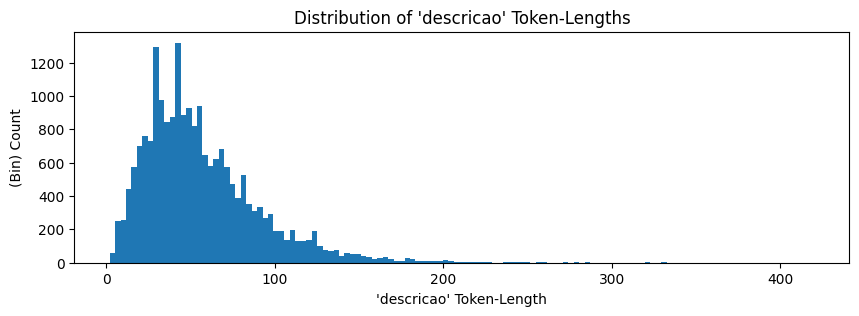

In [4]:
# Studying the distribution of sentence token-lengths on dataframe 'descricao' to make a 
# decision regarding the max sequence length to use for models (also with memory restrictions)
sentence_list = list(ind_df['descricao'].dropna())
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', \
                                          do_lower_case=False)
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in sentence_list]
token_lengths = np.array(token_lengths)

# Printing statistics and finding out that, given the small amount of sentences with more than
# 128 tokens, maybe we don't need to run an entire LLM pipeline to reduce sentence lengths. 
# Having said that, sequence length of 64 is pretty tight and would make us lose around 30%
# of our data with no LLM pipeline to reduce sentences
print("'descricao' token-length statistics:")
print(f"""Min: {np.min(token_lengths)}; Max: {np.max(token_lengths)}; 
Mean: {np.mean(token_lengths)}; std: {np.std(token_lengths)}; 
Mode: {stats.mode(token_lengths)}; 
Q1: {np.quantile(token_lengths, 0.25)}; 
Q2: {np.quantile(token_lengths, 0.50)}; 
Q3: {np.quantile(token_lengths, 0.75)};""")
print(f"How many sentences longer than 128 tokens? {len(np.where(token_lengths > 128)[0])}\n")

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of 'descricao' Token-Lengths")
plt.show()

Due to the very small amount of sentences with more than 128 tokens, and to the fact that, even those, are normally very close to 128 tokens, we first decided to postpone the bulding of an LLM pipeline to summarize longer sentences. Having said that, because of the bad quality of embeddings we got, we later decided to try reducing the sentences to more key aspects of it.

In [5]:
# Defining chucnk_size because we use it later
chunk_size = 20

In [6]:
%%skip

# Concatenating the descriptions an then mapping them to file splits for later API request
for i in range(0, len(sentence_list), chunk_size):
    chunk = sentence_list[i:i+chunk_size]
    file_num = i//chunk_size + 1
    file_name = f"sentences_{file_num}.txt"
    file_path = os.path.join('../data/raw_descriptions', file_name)

    # Removing unwanted line breaks in the middle of the sentences to prevent broken pipeline
    for j, description in enumerate(chunk):
        chunk[j] = description.replace('\n', '. ')
    
    # Write the chunk to file, one sentence per line
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(chunk))

In [7]:
# Function to load files
def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

In [8]:
%%skip

# Initializing API client
groq_key = load_file('../data/groq').strip()
os.environ['OPENAI_API_KEY'] = groq_key
client = OpenAI(
    base_url='https://api.groq.com/openai/v1',
    api_key=os.environ['OPENAI_API_KEY'],
)

# Going through sentences, making request for LLM model and rewriting them
for file in tqdm(os.listdir('../data/raw_descriptions')):
    if 'sentences' not in file:
        continue
    descriptions = load_file(os.path.join('../data/raw_descriptions', file))

    # Keep trying inspite of internal server errors
    try_counter = 0
    while True:
        try:
            response = client.chat.completions.create(
                model='meta-llama/llama-4-maverick-17b-128e-instruct',
                messages=[
                    {
                        'role': 'system',
                        'content': "Para CADA linha do texto (mesmo repetida), gere uma versão reduzida em até 62 tokens, preservando sentido e palavras chaves. Responda com exatamente todas as linhas reduzidas, na mesma ordem, sem introdução.",
                    },
                    {
                        'role': 'user',
                        'content': f'{descriptions}',
                    },
                ],
                temperature=0.3,
                max_tokens=8192,
            )

            # Writing new sentences, but checking for the correct number of (summarized)
            # sentences first
            new_sentences = response.choices[0].message.content.strip()

            if len(new_sentences.split('\n')) != chunk_size and try_counter < 5:
                # So we don't overload the server
                try_counter += 1
                time.sleep(2)
                continue
            
            else:
                try_counter = 0
                with open(os.path.join('../data/summarized_descriptions', file), \
                          'w', encoding='utf-8') as f:
                    f.write(new_sentences)
                break
        
        except Exception as e:
            print(file)
            print(f'Server problem... {e}')
            time.sleep(15)
    
    # Don't exceeed API's (free) limit
    time.sleep(2)

In [9]:
# Checking the files that don't have the exact chunk_size number of descriptions to manually
# fix them
for file in [i for i in os.listdir('../data/summarized_descriptions') if 'sentences' in i]:
    descriptions = load_file(os.path.join('../data/summarized_descriptions', file))
    if len(descriptions.strip().split('\n')) != chunk_size:
        descriptions = descriptions.strip().split('\n')
        print(f"{file} -> {len(descriptions)}")

sentences_1049.txt -> 4


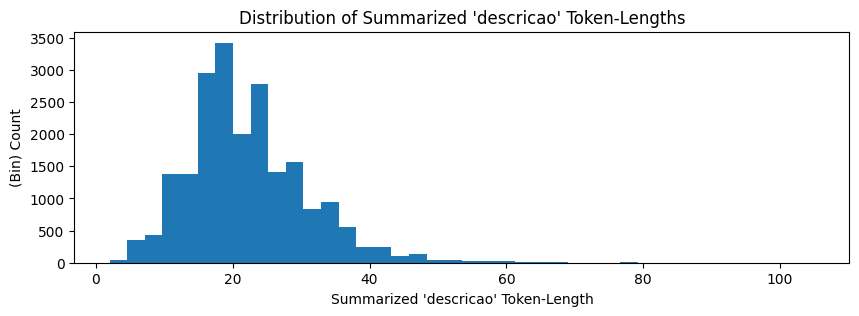

In [10]:
# Helper function to sort by the numeric suffix
def extract_index(file):
    return int(file.split('_')[-1].split('.')[0])

# Getting all (summarized) sentences in proper order
files = glob('../data/summarized_descriptions/sentences_*.txt')
files = sorted(files, key=extract_index)

summarized_sentence_list = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        lines = [line.strip().lower() for line in f if line.strip()]
        summarized_sentence_list.extend(lines)

# Creating column with summarized sentences
ind_df['descricao_resumida'] = ''
ind_df.loc[ind_df['descricao'].isna(), 'descricao_resumida'] = pd.NA
ind_df.loc[ind_df['descricao'].notna(), 'descricao_resumida'] = summarized_sentence_list

# Reanalyzing token distribution in sentences
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in summarized_sentence_list]
token_lengths = np.array(token_lengths)

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("Summarized 'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of Summarized 'descricao' Token-Lengths")
plt.show()

In [11]:
%%skip

# Generating a dataset of positive and negative examples for the contrastive learning using 
# LLMs (so that we don't need to rely on dropout noise for contrastive signal)
for file in tqdm(os.listdir('../data/summarized_descriptions')):
    if 'sentences' not in file:
        continue
    descriptions = load_file(os.path.join('../data/summarized_descriptions', file))

    # Keep trying inspite of internal server errors
    try_counter = 0
    while True:
        try:
            response = client.chat.completions.create(
                model='meta-llama/llama-4-maverick-17b-128e-instruct',
                messages=[
                    {
                        'role': 'system',
                        'content': f"Uma lista de frases será fornecida, uma por linha. Para CADA linha faça duas tarefas: gere uma paráfrase com até 62 tokens e escolha uma outra frase da lista que é a semanticamente mais diferente da frase alvo. Sua resposta deve conter exatamente uma paráfrase e uma negativa para CADA frase original. O formato deve ser 'positivo: <paráfrase> \n negativo: <negativa> \n\n' para cada frase. Não responda mais nada.",
                    },
                    {
                        'role': 'user',
                        'content': f'{descriptions}',
                    },
                ],
                temperature=0.3,
                max_tokens=4096,
            )

            # Writing new sentences, but doing some processing first
            new_sentences = response.choices[0].message.content.strip()

            # Fixing file structure for the common case of no double line-break
            if len(new_sentences.strip().split('\n\n')) == 1:
                even = 0
                fixed_new_sentences = []
                for c in new_sentences.strip():
                    fixed_new_sentences.append(c)
                    if c == '\n':
                        if even:
                            fixed_new_sentences.append('\n')
                        even = 1 - even
                new_sentences = ''.join(fixed_new_sentences)
                        
            # Checking number of sentences
            if len(new_sentences.strip().split('\n\n')) != chunk_size and try_counter < 5:
                # So we don't overload the server
                try_counter += 1
                time.sleep(2)
                continue
            
            else:
                try_counter = 0
                with open(os.path.join('../data/contrastive_triplets', file), \
                          'w', encoding='utf-8') as f:
                    f.write(new_sentences)
                break
        
        except Exception as e:
            print(f'Server problem... {e}')
            time.sleep(15)
    
    # Don't exceeed API's (free) limit
    time.sleep(2)

In [12]:
# Checking the files that don't have the exact chunk_size number of contrastive descriptions
# to manually fix them
for file in [i for i in os.listdir('../data/contrastive_triplets') if 'sentences' in i]:
    descriptions = load_file(os.path.join('../data/contrastive_triplets', file))
    if len(descriptions.strip().split('\n\n')) != chunk_size:
        descriptions = descriptions.strip().split('\n\n')
        print(f"{file} -> {len(descriptions)}")

sentences_1049.txt -> 4


In [13]:
# Getting all (contrastive) sentences in proper order
files = glob('../data/contrastive_triplets/sentences_*.txt')
files = sorted(files, key=extract_index)

# Creating multi-negative contrastive dataset with positive sentences coming from triplets, 
# but negative sentences from other categories
positive_contrastive_sentence_list = []
single_negative_contrastive_sentence_list = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
        positive_contrastive_sentence_list.extend([line.replace('positivo: ', '').lower() \
                                                   for line in lines[::2]])
        single_negative_contrastive_sentence_list.extend(
                                                    [line.replace('negativo: ','').lower() \
                                                     for line in lines[1::2]]
                                                  )

# Creating columns for contrastive sentences
ind_df['positive_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'positive_contrastive'] = pd.NA
ind_df.loc[ind_df['descricao_resumida'].notna(), \
           'positive_contrastive'] = positive_contrastive_sentence_list

ind_df['single_negative_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'single_negative_contrastive'] = pd.NA
ind_df.loc[ind_df['descricao_resumida'].notna(), \
           'single_negative_contrastive'] = single_negative_contrastive_sentence_list

# For multi-negative, we are going to find 5 sentences from other categories
ind_df['multi_negative_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'multi_negative_contrastive'] = pd.NA

# Creating dictionary of samples to make sampling faster
sampling_dict = {c: ind_df.loc[(ind_df['categoria'] != c) & \
                               (ind_df['descricao_resumida'].notna()), \
                               'descricao_resumida'] for c in ind_df['categoria'].unique()}

# Iterating the dataframe and sampling from other 'categoria'
n_samples = 10
for index, row in ind_df.loc[ind_df['descricao_resumida'].notna()].iterrows():
    current_categoria = row['categoria']
    sampled_list = sampling_dict[current_categoria].sample(n=n_samples, replace=False).tolist()
    ind_df.at[index, 'multi_negative_contrastive'] = sampled_list

## BERTimbau

### Vanilla Model

In [14]:
# Getting device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [15]:
# Initializing model, turning it into eval mode and zeroing out the gradients
# base_model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')
base_model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
base_model = base_model.to(device)
base_model.eval()
base_model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao_resumida'].isna()]
max_length = 64
text_dataset = UnsupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 64
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Initializing baseline input_ids and attention_mask, and computing its embedding
baseline_input_ids = torch.full((1, max_length), tokenizer.pad_token_id).to(device)
baseline_input_ids[:, 0] = tokenizer.cls_token_id
baseline_input_ids[:, -1] = tokenizer.sep_token_id
baseline_attention_mask = torch.zeros_like(baseline_input_ids).to(device)
baseline_attention_mask[:, 0] = 1
baseline_attention_mask[:, -1] = 1
with torch.no_grad():
    baseline_outputs = base_model(input_ids=baseline_input_ids, \
                                  attention_mask=baseline_attention_mask)
    baseline_embedding = baseline_outputs.last_hidden_state
    sum_embedding = (baseline_embedding*baseline_attention_mask.unsqueeze(-1).float())\
                    .sum(dim=1)
    lengths = baseline_attention_mask.unsqueeze(-1).float().sum(dim=1).clamp(min=1e-9)
    baseline_embedding = sum_embedding/lengths

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(base_model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, base_model.embeddings)

In [16]:
# Checking model's STS-B score for reference
_ = stsb_test(base_model, device, tokenizer, max_length=max_length, model_loss='vanilla', \
              verbose=True)

# Checking model's in-context STS-B score for reference too
subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(base_model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='vanilla', verbose=True)

STS-B (Pearson): 0.7020
In-Context STS-B (Pearson): 0.7606


In [17]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_bertimbau_indices = []
vanilla_bertimbau_embeddings = []
vanilla_bertimbau_tokens = []
vanilla_bertimbau_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    vanilla_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(base_model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_bertimbau_tokens.append(tokens)
    vanilla_bertimbau_attributions.append(attributions)
    
# Concatenating the batches
vanilla_bertimbau_indices = np.array(vanilla_bertimbau_indices).squeeze(-1)
vanilla_bertimbau_embeddings = np.array(torch.cat(vanilla_bertimbau_embeddings, dim=0))
vanilla_bertimbau_tokens = np.array(vanilla_bertimbau_tokens)
vanilla_bertimbau_attributions = np.array(torch.cat(vanilla_bertimbau_attributions, dim=0))

100%|██████████████████| 20964/20964 [1:09:08<00:00,  5.05it/s]


In [18]:
# Getting data projections
vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap = data_projections(vanilla_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_bertimbau_trimap = normalize(vanilla_bertimbau_trimap, norm_factor)
vanilla_bertimbau_tsne = normalize(vanilla_bertimbau_tsne, norm_factor)
vanilla_bertimbau_umap = normalize(vanilla_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

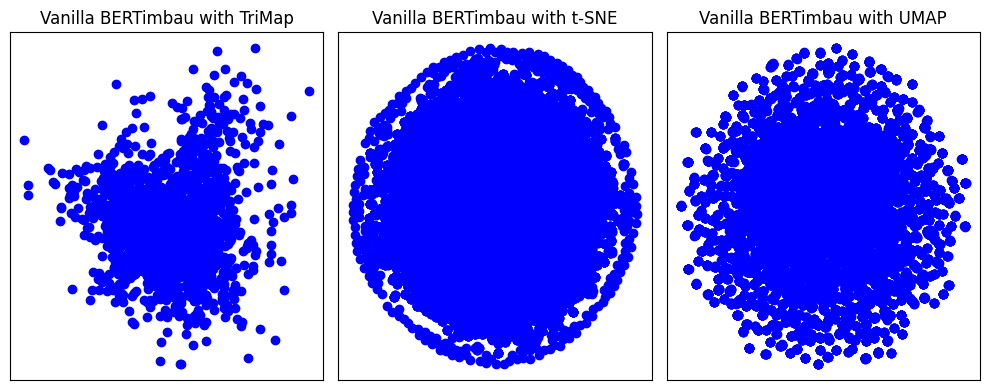

In [19]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=1, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(10,4))
# plt.suptitle('Comparing Projections of BERTimbau Models')

# Plotting vanilla BERTimbau projections
projs = [vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, vanilla_bertimbau_umap]
proj_names = ['Vanilla BERTimbau with TriMap', 'Vanilla BERTimbau with t-SNE', \
              'Vanilla BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [20]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_bertimbau_umap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_umap.csv')

In [21]:
# Cleaning memory
clean_mem([vanilla_bertimbau_embeddings, vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap, vanilla_bertimbau_attributions, vanilla_bertimbau_indices])

### Unsupervised SimCSE (Contrastive Learning with no Labels)

In [ ]:
# Initializing USimCSE model and auxiliar variables
dropout_prob = 0.1
model = USimCSEModel(base_model, tokenizer.pad_token_id, device, dropout_prob)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)
epochs = 15
temperature = 0.05 # Test 0.01, 0.05, 0.1, 0.2
patience = max(3, math.ceil(epochs*0.1))
model_name = 'usimcse_bertimbau'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
usimcse_indices, usimcse_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = usimcse_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

Initial STS-B: 0.6921 | Initial In-Context STS-B: 0.7527


Epoch:   0%|                            | 0/15 [00:00<?, ?it/s]

In [23]:
# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='usimcse', \
              verbose=True)
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='usimcse', verbose=True)

/tmp/ipykernel_3829403/1468265165.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7219
In-Context STS-B (Pearson): 0.8586


In [24]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    model.eval()
    baseline_embedding = model(input_ids=baseline_input_ids)

# Instanciating attribution computation class for fine-tuned model
usimcse_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
usimcse_wrapped_model.eval()
lig = LayerIntegratedGradients(usimcse_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
usimcse_bertimbau_indices = []
usimcse_bertimbau_embeddings = []
usimcse_bertimbau_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    usimcse_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    usimcse_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    usimcse_bertimbau_attributions.append(attributions)

# Concatenating the batches
usimcse_bertimbau_indices = np.array(usimcse_bertimbau_indices).squeeze(-1)
usimcse_bertimbau_embeddings = np.array(torch.cat(usimcse_bertimbau_embeddings, dim=0))
usimcse_bertimbau_attributions = np.array(torch.cat(usimcse_bertimbau_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:07:19<00:00,  5.19it/s]


In [25]:
# Getting data projections
usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, \
usimcse_bertimbau_umap = data_projections(usimcse_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
usimcse_bertimbau_trimap = normalize(usimcse_bertimbau_trimap, norm_factor)
usimcse_bertimbau_tsne = normalize(usimcse_bertimbau_tsne, norm_factor)
usimcse_bertimbau_umap = normalize(usimcse_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

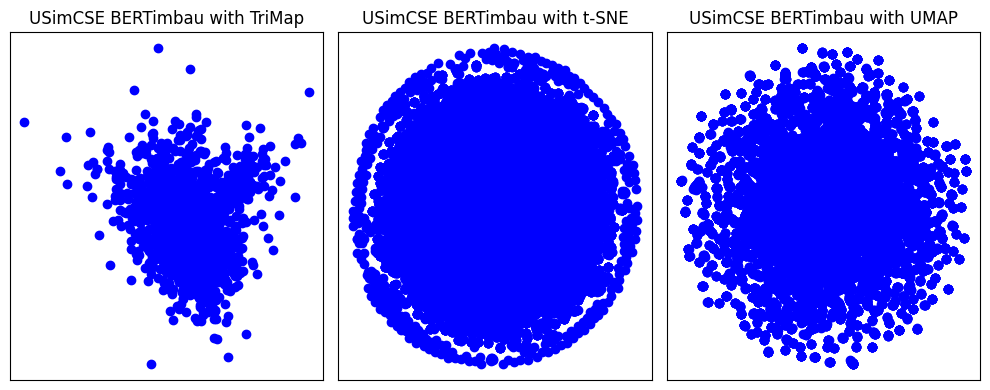

In [26]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE BERTimbau projections
projs = [usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, usimcse_bertimbau_umap]
proj_names = ['USimCSE BERTimbau with TriMap', 'USimCSE BERTimbau with t-SNE', \
              'USimCSE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [27]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(usimcse_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   usimcse_bertimbau_attributions, usimcse_bertimbau_indices, \
                   save_file='usimcse_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(usimcse_bertimbau_umap, vanilla_bertimbau_tokens, \
                   usimcse_bertimbau_attributions, usimcse_bertimbau_indices, \
                   save_file='usimcse_bertimbau_umap.csv')

In [28]:
# Cleaning memory
clean_mem([usimcse_bertimbau_embeddings, usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, \
usimcse_bertimbau_umap, usimcse_bertimbau_attributions, usimcse_bertimbau_indices])

###  Supervised InfoNCE (Contrastive Learning with Labels)

In [ ]:
import language_training_utils
importlib.reload(language_training_utils)
from language_training_utils import *

# Initializing InfoNCEModel model and auxiliar variables
model = InfoNCEModel(base_model, tokenizer.pad_token_id, device, hidden_dim=768, proj_dim=512)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 15
temperature = 0.07 # Test 0.03, 0.07, 0.1, 0.3
patience = max(3, math.ceil(epochs*0.1))
model_name = 'infonce_bertimbau'

# Getting sentences' dataset, dataloader and splits again (now for a supervised dataset)
max_length = 64
text_dataset = SupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)
split_batch_size = 8
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
infonce_indices, infonce_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = infonce_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

Initial STS-B: 0.7925 | Initial In-Context STS-B: 0.8500


Epoch:   0%|                            | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.0015 | Val Loss: 0.0002 | STS-B: 0.7779 | in-context STS-B: 0.8443


Epoch:   7%|█               | 1/15 [19:04<4:27:00, 1144.29s/it]

New best model found!
Epoch 2/15 | Train Loss: 0.0005 | Val Loss: 0.0002 | STS-B: 0.7829 | in-context STS-B: 0.8484


Epoch:  13%|██▏             | 2/15 [38:08<4:07:55, 1144.28s/it]

New best model found!
Epoch 3/15 | Train Loss: 0.0001 | Val Loss: 0.0001 | STS-B: 0.7850 | in-context STS-B: 0.8498


Epoch:  20%|███▏            | 3/15 [57:13<3:48:54, 1144.54s/it]

New best model found!


Epoch:  27%|███▋          | 4/15 [1:16:16<3:29:43, 1143.98s/it]

Epoch 4/15 | Train Loss: 0.0001 | Val Loss: 0.0001 | STS-B: 0.7851 | in-context STS-B: 0.8465


Epoch:  33%|████▋         | 5/15 [1:35:21<3:10:43, 1144.31s/it]

Epoch 5/15 | Train Loss: 0.0000 | Val Loss: 0.0001 | STS-B: 0.7811 | in-context STS-B: 0.8426


Epoch:  40%|█████▌        | 6/15 [1:54:25<2:51:38, 1144.24s/it]

Epoch 6/15 | Train Loss: 0.0001 | Val Loss: 0.0003 | STS-B: 0.7844 | in-context STS-B: 0.8453


Epoch:  47%|██████▌       | 7/15 [2:13:45<2:33:14, 1149.26s/it]

Epoch 7/15 | Train Loss: 0.0001 | Val Loss: 0.0005 | STS-B: 0.7860 | in-context STS-B: 0.8418


Epoch:  53%|███████▍      | 8/15 [2:33:06<2:14:32, 1153.26s/it]

Epoch 8/15 | Train Loss: 0.0000 | Val Loss: 0.0005 | STS-B: 0.7817 | in-context STS-B: 0.8370


Epoch:  60%|████████▍     | 9/15 [2:52:14<1:55:09, 1151.56s/it]

Epoch 9/15 | Train Loss: 0.0000 | Val Loss: 0.0003 | STS-B: 0.7807 | in-context STS-B: 0.8334


In [ ]:
# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='infonce', \
              verbose=True)

subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='infonce', verbose=True)

In [ ]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    model.eval()
    baseline_embedding = model(input_ids=baseline_input_ids)

# Instanciating attribution computation class for fine-tuned model
infonce_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
infonce_wrapped_model.eval()
lig = LayerIntegratedGradients(infonce_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
infonce_bertimbau_indices = []
infonce_bertimbau_embeddings = []
infonce_bertimbau_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    infonce_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    infonce_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    infonce_bertimbau_attributions.append(attributions)

# Concatenating the batches
infonce_bertimbau_indices = np.array(infonce_bertimbau_indices).squeeze(-1)
infonce_bertimbau_embeddings = np.array(torch.cat(infonce_bertimbau_embeddings, dim=0))
infonce_bertimbau_attributions = np.array(torch.cat(infonce_bertimbau_attributions, dim=0))

In [ ]:
# Getting data projections
infonce_bertimbau_trimap, infonce_bertimbau_tsne, \
infonce_bertimbau_umap = data_projections(infonce_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
infonce_bertimbau_trimap = normalize(infonce_bertimbau_trimap, norm_factor)
infonce_bertimbau_tsne = normalize(infonce_bertimbau_tsne, norm_factor)
infonce_bertimbau_umap = normalize(infonce_bertimbau_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting InfoNCE BERTimbau projections
projs = [infonce_bertimbau_trimap, infonce_bertimbau_tsne, infonce_bertimbau_umap]
proj_names = ['InfoNCE BERTimbau with TriMap', 'InfoNCE BERTimbau with t-SNE', \
              'InfoNCE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(infonce_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   infonce_bertimbau_attributions, infonce_bertimbau_indices, \
                   save_file='infonce_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(infonce_bertimbau_umap, vanilla_bertimbau_tokens, \
                   infonce_bertimbau_attributions, infonce_bertimbau_indices, \
                   save_file='infonce_bertimbau_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([infonce_bertimbau_embeddings, infonce_bertimbau_trimap, infonce_bertimbau_tsne, \
infonce_bertimbau_umap, infonce_bertimbau_attributions, infonce_bertimbau_indices])

## Albertina

### Vanilla Model

In [15]:
# Getting new tokenizer
# tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder', \
#                                           use_fast=True)
tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder', \
                                          use_fast=True)

# Initializing model, turning it into eval mode and zeroing out the gradients
# model = AutoModel.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder')
base_model = AutoModel.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder')
base_model = base_model.to(device)
base_model.eval()
base_model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao_resumida'].isna()]
max_length = 64
text_dataset = UnsupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 32
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Initializing baseline input_ids and attention_mask, and computing its embedding
baseline_input_ids = torch.full((1, max_length), tokenizer.pad_token_id).to(device)
baseline_input_ids[:, 0] = tokenizer.cls_token_id
baseline_input_ids[:, -1] = tokenizer.sep_token_id
baseline_attention_mask = torch.zeros_like(baseline_input_ids).to(device)
baseline_attention_mask[:, 0] = 1
baseline_attention_mask[:, -1] = 1
with torch.no_grad():
    baseline_outputs = base_model(input_ids=baseline_input_ids, \
                                  attention_mask=baseline_attention_mask)
    baseline_embedding = baseline_outputs.last_hidden_state
    sum_embedding = (baseline_embedding*baseline_attention_mask.unsqueeze(-1).float())\
                    .sum(dim=1)
    lengths = baseline_attention_mask.unsqueeze(-1).float().sum(dim=1).clamp(min=1e-9)
    baseline_embedding = sum_embedding/lengths

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(base_model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, base_model.embeddings)

In [18]:
# Checking model's STS-B score for reference
_ = stsb_test(base_model, device, tokenizer, max_length=max_length, model_loss='vanilla', \
              verbose=True)

# Checking model's in-context STS-B score for reference too
subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(base_model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='vanilla', verbose=True)

STS-B (Pearson): 0.6896
In-Context STS-B (Pearson): 0.6890


In [20]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_albertina_indices = []
vanilla_albertina_embeddings = []
vanilla_albertina_tokens = []
vanilla_albertina_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    vanilla_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(base_model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_albertina_tokens.append(tokens)
    vanilla_albertina_attributions.append(attributions)
    
# Concatenating the batches
vanilla_albertina_indices = np.array(vanilla_albertina_indices).squeeze(-1)
vanilla_albertina_embeddings = np.array(torch.cat(vanilla_albertina_embeddings, dim=0))
vanilla_albertina_tokens = np.array(vanilla_albertina_tokens)
vanilla_albertina_attributions = np.array(torch.cat(vanilla_albertina_attributions, dim=0))

  0%|                     | 54/20964 [00:14<1:32:33,  3.77it/s]


KeyboardInterrupt: 

In [ ]:
# Getting data projections
vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap = data_projections(vanilla_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_albertina_trimap = normalize(vanilla_albertina_trimap, norm_factor)
vanilla_albertina_tsne = normalize(vanilla_albertina_tsne, norm_factor)
vanilla_albertina_umap = normalize(vanilla_albertina_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE BERTimbau projections
projs = [vanilla_albertina_trimap, vanilla_albertina_tsne, vanilla_albertina_umap]
proj_names = ['Vanilla Albertina with TriMap', 'Vanilla Albertina with t-SNE', \
              'Vanilla Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_albertina_trimap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_albertina_umap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_umap.csv')

In [21]:
# Cleaning memory
clean_mem([vanilla_albertina_embeddings, vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap, vanilla_albertina_attributions, vanilla_albertina_indices])

NameError: name 'vanilla_albertina_trimap' is not defined

### Unsupervised SimCSE (Contrastive Learning with no Labels)

In [16]:
# Initializing USimCSE model and auxiliar variables
dropout_prob = 0.1
model = USimCSEModel(base_model, tokenizer.pad_token_id, device, dropout_prob)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)
epochs = 15
temperature = 0.05 # Test 0.01, 0.05, 0.1, 0.2
patience = max(3, math.ceil(epochs*0.1))
model_name = 'usimcse_albertina'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
usimcse_indices, usimcse_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = usimcse_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

Initial STS-B: 0.1314 | Initial In-Context STS-B: 0.1144


Epoch:   0%|                            | 0/15 [04:43<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='usimcse', \
              verbose=True)
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='usimcse', verbose=True)

In [ ]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    model.eval()
    baseline_embedding = model(input_ids=baseline_input_ids)

# Instanciating attribution computation class for fine-tuned model
usimcse_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
usimcse_wrapped_model.eval()
lig = LayerIntegratedGradients(usimcse_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
usimcse_albertina_indices = []
usimcse_albertina_embeddings = []
usimcse_albertina_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    usimcse_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    usimcse_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    usimcse_albertina_attributions.append(attributions)

# Concatenating the batches
usimcse_albertina_indices = np.array(usimcse_albertina_indices).squeeze(-1)
usimcse_albertina_embeddings = np.array(torch.cat(usimcse_albertina_embeddings, dim=0))
usimcse_albertina_attributions = np.array(torch.cat(usimcse_albertina_attributions, dim=0))

In [ ]:
# Getting data projections
usimcse_albertina_trimap, usimcse_albertina_tsne, \
usimcse_albertina_umap = data_projections(usimcse_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
usimcse_albertina_trimap = normalize(usimcse_albertina_trimap, norm_factor)
usimcse_albertina_tsne = normalize(usimcse_albertina_tsne, norm_factor)
usimcse_albertina_umap = normalize(usimcse_albertina_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE Albertina projections
projs = [usimcse_albertina_trimap, usimcse_albertina_tsne, usimcse_albertina_umap]
proj_names = ['USimCSE Albertina with TriMap', 'USimCSE Albertina with t-SNE', \
              'USimCSE Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(usimcse_albertina_trimap, vanilla_albertina_tokens, \
                   usimcse_albertina_attributions, usimcse_albertina_indices, \
                   save_file='usimcse_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(usimcse_albertina_umap, vanilla_albertina_tokens, \
                   usimcse_albertina_attributions, usimcse_albertina_indices, \
                   save_file='usimcse_albertina_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([usimcse_albertina_embeddings, usimcse_albertina_trimap, usimcse_albertina_tsne, \
usimcse_albertina_umap, usimcse_albertina_attributions, usimcse_albertina_indices])

###  Supervised InfoNCE (Contrastive Learning with Labels)

In [16]:
# Initializing InfoNCEModel model and auxiliar variables
model = InfoNCEModel(base_model, tokenizer.pad_token_id, device, hidden_dim=768, proj_dim=512)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 15
temperature = 0.07 # Test 0.03, 0.07, 0.1, 0.3
patience = max(3, math.ceil(epochs*0.1))
model_name = 'infonce_bertimbau'

# Getting sentences' dataset, dataloader and splits again (now for a supervised dataset)
max_length = 64
text_dataset = SupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)
split_batch_size = 4
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
infonce_indices, infonce_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = infonce_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

Initial STS-B: 0.6896 | Initial In-Context STS-B: 0.6692


Epoch:   0%|                            | 0/15 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='infonce', \
              verbose=True)

subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='infonce', verbose=True)

In [ ]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    model.eval()
    baseline_embedding = model(input_ids=baseline_input_ids)

# Instanciating attribution computation class for fine-tuned model
infonce_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
infonce_wrapped_model.eval()
lig = LayerIntegratedGradients(infonce_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
infonce_albertina_indices = []
infonce_albertina_embeddings = []
infonce_albertina_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    infonce_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    infonce_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    infonce_albertina_attributions.append(attributions)

# Concatenating the batches
infonce_albertina_indices = np.array(infonce_albertina_indices).squeeze(-1)
infonce_albertina_embeddings = np.array(torch.cat(infonce_albertina_embeddings, dim=0))
infonce_albertina_attributions = np.array(torch.cat(infonce_albertina_attributions, dim=0))

In [ ]:
# Getting data projections
infonce_albertina_trimap, infonce_albertina_tsne, \
infonce_albertina_umap = data_projections(infonce_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
infonce_albertina_trimap = normalize(infonce_albertina_trimap, norm_factor)
infonce_albertina_tsne = normalize(infonce_albertina_tsne, norm_factor)
infonce_albertina_umap = normalize(infonce_albertina_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting InfoNCE Albertina projections
projs = [infonce_albertina_trimap, infonce_albertina_tsne, infonce_albertina_umap]
proj_names = ['InfoNCE Albertina with TriMap', 'InfoNCE Albertina with t-SNE', \
              'InfoNCE Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(infonce_albertina_trimap, vanilla_albertina_tokens, \
                   infonce_albertina_attributions, infonce_albertina_indices, \
                   save_file='infonce_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(infonce_albertina_umap, vanilla_albertina_tokens, \
                   infonce_albertina_attributions, infonce_albertina_indices, \
                   save_file='infonce_albertina_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([infonce_albertina_embeddings, infonce_albertina_trimap, infonce_albertina_tsne, \
infonce_albertina_umap, infonce_albertina_attributions, infonce_albertina_indices])